In [2]:
# General packages
import pandas as pd
import pickle

# Text Processing
import nltk
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
from sklearn.feature_extraction.text import CountVectorizer

# Topic Modelling
from corextopic import corextopic as ct

# Plots
import matplotlib.pyplot as plt

### Check for Spam/Duplicate comments

In [4]:
df = pd.read_csv('Data/travel_comments.csv')
print(f"Total comments is: {len(df['Comment'])}")
print(f"Unique comments is: {len(df['Comment'].unique())}")

Total comments is: 7639
Unique comments is: 7058


### Remove Spam/Duplicates rows

In [5]:
print('Travel Comments')
print('-'*20)
print(f"Before cleaning: {len(df['Comment'])}")

df.drop_duplicates(subset=['Comment'], inplace=True)
print(f"After cleaning: {len(df['Comment'])}")

Travel Comments
--------------------
Before cleaning: 7639
After cleaning: 7058


# Semi-supervised Topic Modeling (CorEx)

### Creating the BOW model and all the unique words in the corpus

In [6]:
# df = pd.read_csv('travel_comments.csv')

def get_corex_vectorizer_vocab(df):
    comments = []
    for row in df['Comment']:
        text_tokenize = word_tokenize(row)
        text_lower = [w.lower() for w in text_tokenize]
        text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)]
        text_drop_2letters = [w for w in text_words_only if len(w) > 2]
        text_joined = ' '.join(text_drop_2letters)
        comments.append(text_joined)

    df['Comment'] = comments

    vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
    vectorizer = vectorizer.fit(df['Comment'])
    vecs = vectorizer.transform(df['Comment'])
    vocab = vectorizer.get_feature_names()

    return vecs, vocab

vecs, vocab = get_corex_vectorizer_vocab(df=df)
len(vocab)

64626

### Creating anchor words for CorEx model to guide words to fall into each guided topic

In [7]:
anchor_words = [
   # Topic 1: GPE
   ['singapore', 'malaysia', 'united states', 'india', 'indonesia', 'china', 'germany', 'hong kong', 'united kingdom', 'japan'],

   # Topic 2: PERSON
   ['rs lin', 'cov fox bbc', 'boba fett', 'allen chua', 'jesus', 'foreign workers', 'peter kroll', 'richard wong', 'lisa lim', 'pm lee'],

   # Topic 3: ORG
   ['moh', 'lah', 'cnn', 'cdc places', 'channel news asia', 'parliament', 'govt', 'sia', 'vote peoples action party', 'united states'],

   # Topic 4: EVENT
   ['covid', 'omicron', 'delta', 'social distancing', 'coronavirus', 'wuhan virus', 'safe distancing', 'covid variant', 'safeentry', 'circuit breaker'],
   
   # Topic 5: NORP
   ['singaporeans', 'singaporean', 'johor', 'malaysian', 'chinese', 'indian', 'indonesian', 'european', 'asian', 'african']
]

### Training the CorEx model

In [8]:
import time
start_time = time.time()

anchored_topic_model = ct.Corex(n_hidden=5, seed=2)
anchored_topic_model.fit(vecs, words=vocab, anchors=anchor_words, anchor_strength=6)

print("---Training of CorEx model completed ---")
print("Time taken: %s seconds" % (time.time() - start_time))

---Training of CorEx model completed ---
Time taken: 139.0783007144928 seconds


### Getting the top words for each topic

In [9]:
def print_corex_top_topic_words(model, n_words):
    for n in range(n_words):
        topic_words,_,_ = zip(*model.get_topics(topic = n))
        print('Topic #{}: '.format(n+1) + ', '.join(topic_words))
        print()
print_corex_top_topic_words(model=anchored_topic_model, n_words=5)

Topic #1: singapore, malaysia, united states, india, germany, indonesia, hong kong, united kingdom, japan, china

Topic #2: boba fett, allen chua, lisa lim, richard wong, jesus, foreign workers, boba, fett, wong, chua

Topic #3: united states, govt, lah, states, united, moh, parliament, cnn, like, pore govt

Topic #4: covid, omicron, delta, covid nineteen, nineteen, coronavirus, social distancing, covid cases, cases, safe distancing

Topic #5: singaporeans, singaporean, johor, malaysian, chinese, asian, indian, european, african, indonesian



### Plot the total correlation plot to check the correlation score for each topic

Text(0, 0.5, 'Total Correlation (nats)')

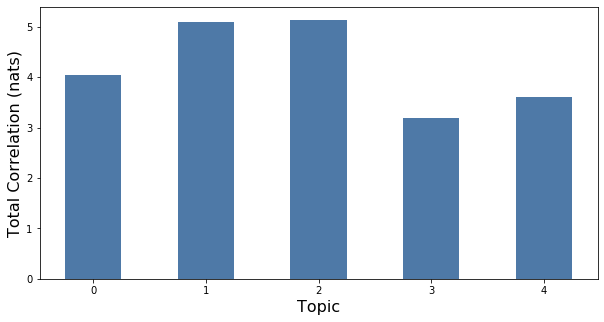

In [10]:
# def plot_corex_total_correlation(model):
#     plt.figure(figsize=(10,5))
#     plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
#     plt.xlabel('Topic', fontsize=16)
#     plt.ylabel('Total Correlation (nats)', fontsize=16)
# plot_corex_total_correlation(model=anchored_topic_model)
plt.figure(figsize=(10,5))
plt.bar(range(anchored_topic_model.tcs.shape[0]), anchored_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)

### Label topics for each comment

In [11]:
def corex_label_topics(df, model, vecs, no_topics):
    topic_df = pd.DataFrame(model.transform(vecs), columns=["topic_{}".format(i+1) for i in range (no_topics)]).astype(float)
    topic_df.index = df.index
    df = pd.concat([df, topic_df], axis=1)
    return df

dominant_topics = corex_label_topics(df=df, model=anchored_topic_model, vecs=vecs, no_topics=5)

dominant_topics.head(5)

,Comment,topic_1,topic_2,topic_3,topic_4,topic_5
0,you have book the pcr test klia before arrival,0.0,0.0,0.0,0.0,0.0
1,access good information what investors need pr...,0.0,0.0,0.0,0.0,0.0
2,please include philippines also are super stre...,0.0,0.0,1.0,0.0,0.0
3,omicron mutated times thats making existing va...,1.0,0.0,1.0,1.0,0.0
4,they are welcoming omicron into singapore when...,1.0,0.0,0.0,1.0,1.0


In [23]:
# dominant_topics.to_csv('travel_topics_topic_labels.csv')

# Sentiment Analysis

In [12]:
# Sentiments
def get_sentiments(df):
    df = vader_sentiment(df)
    df = textblob_sentiment(df)
    df['final_sentiment'] = df['Vader_compound_score'] + df['tb_polarity']

    return df

def vader_sentiment(df):
    df['Vader_compound_score'] = df['Comment'].apply(lambda x: vader_compound_score(x))
    return df

def vader_compound_score(x):
    vader_analyser = SentimentIntensityAnalyzer()
    score = vader_analyser.polarity_scores(x)
    return score['compound']

def textblob_sentiment(df):
    df['tb_polarity'] = df['Comment'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['tb_subjectivity'] = df['Comment'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

### Get overview sentiments of comments for all topics

In [13]:
df_sentiments = get_sentiments(dominant_topics)
# df_sentiments.to_csv('travel_topics_sentiment_labels.csv')

KeyboardInterrupt: 

In [14]:
def get_num_comments_sentiments_by_topic(topics_df, topic):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)

    df_sentiments_pos = df_sentiments[df_sentiments['final_sentiment'] > 0]
    df_sentiments_neu = df_sentiments[df_sentiments['final_sentiment'] == 0]
    df_sentiments_neg = df_sentiments[df_sentiments['final_sentiment'] < 0]
    
    print(f"There are {len(df_sentiments_pos)} positive comments regarding topic {topic}.")
    print(f"There are {len(df_sentiments_neu)} neutral comments regarding topic {topic}.")
    print(f"There are {len(df_sentiments_neg)} negative comments regarding topic {topic}.\n")

In [15]:
get_num_comments_sentiments_by_topic(topics_df=dominant_topics, topic=1)
get_num_comments_sentiments_by_topic(topics_df=dominant_topics, topic=2)
get_num_comments_sentiments_by_topic(topics_df=dominant_topics, topic=3)
get_num_comments_sentiments_by_topic(topics_df=dominant_topics, topic=4)
get_num_comments_sentiments_by_topic(topics_df=dominant_topics, topic=5)

There are 1229 positive comments regarding topic 1.
There are 231 neutral comments regarding topic 1.
There are 607 negative comments regarding topic 1.

There are 677 positive comments regarding topic 2.
There are 71 neutral comments regarding topic 2.
There are 413 negative comments regarding topic 2.

There are 723 positive comments regarding topic 3.
There are 50 neutral comments regarding topic 3.
There are 413 negative comments regarding topic 3.

There are 733 positive comments regarding topic 4.
There are 86 neutral comments regarding topic 4.
There are 488 negative comments regarding topic 4.

There are 716 positive comments regarding topic 5.
There are 80 neutral comments regarding topic 5.
There are 426 negative comments regarding topic 5.



### Get top positive/neutral/negative comments under a topic

In [16]:
def get_corex_top_positive_comments(topics_df, topic, n):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)

    df_sentiments_pos = df_sentiments[df_sentiments['final_sentiment'] > 0]
    # df_sentiments_pos.to_csv('df_sentiments_pos_topic_2.csv')

    print(f"There are {len(df_sentiments_pos)} positive comments regarding topic {topic}. {round(len(df_sentiments_pos)/len(df_sentiments), 2) * 100} % of the comments are positive for this topic.\n\n")
    
    positive_comments = df_sentiments_pos.sort_values(by='final_sentiment', ascending=False)['Comment'].to_list()

    print_top_comments(positive_comments, n)

def get_corex_neutral_comments(topics_df, topic, n):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)


    df_sentiments_neu = df_sentiments[df_sentiments['final_sentiment'] == 0]
    # df_sentiments_neu_2.to_csv('df_sentiments_neu_topic_2.csv')

    print(f"There are {len(df_sentiments_neu)} neutral comments regarding topic {topic}. {round(len(df_sentiments_neu)/len(df_sentiments), 2) * 100} % of the comments are neutral for this topic.\n\n")
    
    comments = df_sentiments_neu['Comment'].sample(n=n).to_list()

    print_comments(comments, n)

def get_corex_top_negative_comments(topics_df, topic, n):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)

    df_sentiments_neg = df_sentiments[df_sentiments['final_sentiment'] < 0]
    print(f"There are {len(df_sentiments_neg)} negative comments regarding topic {topic}. {round(len(df_sentiments_neg)/len(df_sentiments), 2) * 100} % of the comments are negative for this topic.\n\n")
    
    # comments = df_sentiments_neg['Comment'].sample(n=n).to_list()
    negative_comments = df_sentiments_neg.sort_values(by='final_sentiment', ascending=True)['Comment'].to_list()

    print_top_comments(negative_comments, n)

def print_top_comments(comments, n):
    for i in range(n):
        print(f'Rank {i+1} comment:')
        print(f'{comments[i]}')
        print()

def print_comments(comments, n):
    for i in range(n):
        print(f'Comment {i+1}')
        print(f'{comments[i]}')
        print()

##### Topic 1

In [42]:
# positive comments for Topic 1
get_corex_top_positive_comments(topics_df=dominant_topics, topic=1, n=5)

There are 1229 positive comments regarding topic 1. 59.0 % of the comments are positive for this topic.


Rank 1 comment:
the best thing that has ever happened united states allows united states wfh

Rank 2 comment:
mohd countries like congo indonesia philippines and malaysia who are corrupted are invited they got best democracy even united states where got riots the capitol building and donald trump can talk abt democracy

Rank 3 comment:
eight continues can cme here spread but got chance spread sounds fair singapore ministers fucxxx fuxx off don talk please tell united states something make united states happy

Rank 4 comment:
mark zuckerbird like someone bought umbrella but they need united states buy one protect them from the rain lol

Rank 5 comment:
thailand please can not eat all the delicious and cheap thai foods and see all their beautiful women lol



In [43]:
# neutral comments for Topic 1
get_corex_neutral_comments(topics_df=dominant_topics, topic=1, n=5)

There are 231 neutral comments regarding topic 1. 11.0 % of the comments are neutral for this topic.


Comment 1
monka eternal mine not valid singapore also got cases are also bringing cases over pcr tests dun work

Comment 2
not ask singapore ask the destination country

Comment 3
maybe you should move taiwan china

Comment 4
can take boat train malaysia need vaccinated travel lane

Comment 5
what about india



In [44]:
# negative comments for Topic 1
get_corex_top_negative_comments(topics_df=dominant_topics, topic=1, n=5)

There are 607 negative comments regarding topic 1. 28.999999999999996 % of the comments are negative for this topic.


Rank 1 comment:
andylau google reporters without borders just deleted malaysia posts again one linked another explanation google contemptible and disgusting shitty paper

Rank 2 comment:
pap trying earn money and does not care about united states getting covid nineteen become sick die earning money out our misery and the corpse covid nineteen death absolutely inhumane

Rank 3 comment:
then why allow vaccinated travel lane into singapore all affected are coming singapore aggravate the situation disgusting

Rank 4 comment:
lin nothing with singapore how about germany then they are too having worst outbreak pandemic eversince vaccinated travel lane with singapore coincidence

Rank 5 comment:
schadenfreude that insulting singapore education system



##### Topic 4

In [31]:
# positive comments for Topic 4
get_corex_top_positive_comments(topics_df=dominant_topics, topic=4, n=5)

There are 733 positive comments regarding topic 4. 56.00000000000001 % of the comments are positive for this topic.


Rank 1 comment:
avijeet well tell that the doctor who presented his work and lab studies the covid gop conference the guy has been working covid since sars unbiaised has one the best credentials with regards this virus

Rank 2 comment:
angmo boss very happy more rrt thought won hope contract covid lorry soon

Rank 3 comment:
slumps perfect one hundred ranking covid recovery index source nikkei asia five nov

Rank 4 comment:
peter mish agree with you covid nineteen taught united states the importance having plan good all believe all can relate this

Rank 5 comment:
love singapore but not take medicines and injections and stay home but know the maks not anything but will wear one keep from getting fined malaysia groceries were delivered malaysia home before the call pandemic moved queretaro mexico eleven two two thousand and where safe beautiful and clean like singapore



In [32]:
# neutral comments for Topic 4
get_corex_neutral_comments(topics_df=dominant_topics, topic=4, n=5)

There are 86 neutral comments regarding topic 4. 7.000000000000001 % of the comments are neutral for this topic.


Comment 1
omicron coming faster than getting the data

Comment 2
when this when everyone has contracted covid

Comment 3
what the daily infection rate pore from fourteen feb nineteen feb two thousand and

Comment 4
what happens when different countries have different definitions fully vaccinated you end the day still vaccinated travel lane but only another shape and form

Comment 5
onky living with covid ever changing restrictions



In [15]:
# negative comments for Topic 4
get_corex_top_negative_comments(topics_df=dominant_topics, topic=4, n=5)

There are 488 negative comments regarding topic 4. 37.0 % of the comments are negative for this topic.


Rank 1 comment:
andylau google reporters without borders just deleted malaysia posts again one linked another explanation google contemptible and disgusting shitty paper

Rank 2 comment:
pap trying earn money and does not care about united states getting covid nineteen become sick die earning money out our misery and the corpse covid nineteen death absolutely inhumane

Rank 3 comment:
hate covid hate covid hate covid hate covid hate covid

Rank 4 comment:
dislike comment section because has been infected with dangerous virus worst than covid

Rank 5 comment:
expect covid cases get worst



# Emotion Analysis

### Label emotions for each comment

In [17]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [18]:
def emotions(df):
    emotions_clf = pickle.load(open('Data/tfidf_svm.sav', 'rb'))
    df['Emotion'] = df['Comment'].apply(lambda x: emotions_clf.predict([x]))
    return df

df_emot = emotions(dominant_topics)
df_emot.head(5)

C:\Users\tl_ch\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\tl_ch\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\tl_ch\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\tl_ch\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your o

,Comment,topic_1,topic_2,topic_3,topic_4,topic_5,Emotion
0,you have book the pcr test klia before arrival,0.0,0.0,0.0,0.0,0.0,[fear]
1,access good information what investors need pr...,0.0,0.0,0.0,0.0,0.0,[neutral]
2,please include philippines also are super stre...,0.0,0.0,1.0,0.0,0.0,[joy]
3,omicron mutated times thats making existing va...,1.0,0.0,1.0,1.0,0.0,[fear]
4,they are welcoming omicron into singapore when...,1.0,0.0,0.0,1.0,1.0,[anger]


### Get overview emotions of comments for all topics

In [38]:
def get_num_comments_by_emotions_by_topic(topics_df, topic):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    comments_joy = df[df['Emotion'] == 'joy'].reset_index()
    comments_sad = df[df['Emotion'] == 'sadness'].reset_index()
    comments_anger = df[df['Emotion'] == 'anger'].reset_index()
    comments_neu = df[df['Emotion'] == 'neutral'].reset_index()
    comments_fear = df[df['Emotion'] == 'fear'].reset_index()

    print(f"There are {len(comments_joy)} joy comments regarding topic {topic}.")
    print(f"There are {len(comments_sad)} sadness comments regarding topic {topic}.")
    print(f"There are {len(comments_anger)} anger comments regarding topic {topic}.")
    print(f"There are {len(comments_neu)} neutral comments regarding topic {topic}.")
    print(f"There are {len(comments_fear)} fear comments regarding topic {topic}.\n")

In [39]:
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=1)
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=2)
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=3)
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=4)
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=5)

There are 230 joy comments regarding topic 1.
There are 245 sadness comments regarding topic 1.
There are 260 anger comments regarding topic 1.
There are 946 neutral comments regarding topic 1.
There are 386 fear comments regarding topic 1.

There are 151 joy comments regarding topic 2.
There are 162 sadness comments regarding topic 2.
There are 206 anger comments regarding topic 2.
There are 358 neutral comments regarding topic 2.
There are 284 fear comments regarding topic 2.

There are 165 joy comments regarding topic 3.
There are 148 sadness comments regarding topic 3.
There are 178 anger comments regarding topic 3.
There are 464 neutral comments regarding topic 3.
There are 231 fear comments regarding topic 3.

There are 161 joy comments regarding topic 4.
There are 174 sadness comments regarding topic 4.
There are 219 anger comments regarding topic 4.
There are 448 neutral comments regarding topic 4.
There are 305 fear comments regarding topic 4.

There are 143 joy comments regar

### Get top comments by emotions

In [19]:
def get_top_comments_by_emotions(df, emotion, n):
    df_sentiments = get_sentiments(df)

    comments_emotion = df_sentiments[df_sentiments['Emotion'] == emotion].reset_index()

    if emotion == 'joy':
        comments = comments_emotion.sort_values(by='final_sentiment', ascending=False)['Comment'].to_list()
    else:
        comments = comments_emotion.sort_values(by='final_sentiment', ascending=True)['Comment'].to_list()
    

    print_top_comments(comments, n)

def get_corex_top_comments_by_emotions(topics_df, topic, emotion, n):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()
    
    df_sentiments = get_sentiments(df)

    comments_emotion = df_sentiments[df_sentiments['Emotion'] == emotion].reset_index()

    if emotion == 'joy':
        comments = comments_emotion.sort_values(by='final_sentiment', ascending=False)['Comment'].to_list()
    else:
        comments = comments_emotion.sort_values(by='final_sentiment', ascending=True)['Comment'].to_list()
    

    print_top_comments(comments, n)

In [21]:
get_top_comments_by_emotions(df=df_emot, emotion='joy', n=5)

Rank 1 comment:
avijeet well tell that the doctor who presented his work and lab studies the covid gop conference the guy has been working covid since sars unbiaised has one the best credentials with regards this virus

Rank 2 comment:
mohd countries like congo indonesia philippines and malaysia who are corrupted are invited they got best democracy even united states where got riots the capitol building and donald trump can talk abt democracy

Rank 3 comment:
eight continues can cme here spread but got chance spread sounds fair singapore ministers fucxxx fuxx off don talk please tell united states something make united states happy

Rank 4 comment:
mark zuckerbird like someone bought umbrella but they need united states buy one protect them from the rain lol

Rank 5 comment:
hope can visit batam soon beautiful adventure and looking forward



In [20]:
get_corex_top_comments_by_emotions(topics_df=df_emot, topic=4, emotion='sadness', n=5)

Rank 1 comment:
pap trying earn money and does not care about united states getting covid nineteen become sick die earning money out our misery and the corpse covid nineteen death absolutely inhumane

Rank 2 comment:
such cold hearted measure for seniors who are not vaccinated they fell shall will regardless covid infection they might hesitate see doctor for the concern medical cost here you are suggesting them suffer and die alone home the worst case you regard them suicidal and neglect them

Rank 3 comment:
wrong the person died with omicron not omicron you need see past the word games they play the person was elderly cancer patient

Rank 4 comment:
only stupid people believe that living with covid nineteen can work live with covid nineteen means everyone will infected covid nineteen and get sick even die and have long term implication

Rank 5 comment:
hide malaysia test paper from malaysia mom when fail the test that one know lazy



In [21]:
get_corex_top_comments_by_emotions(topics_df=df_emot, topic=4, emotion='fear', n=5)

Rank 1 comment:
dislike comment section because has been infected with dangerous virus worst than covid

Rank 2 comment:
fiost the worst yet come and will made covid nineteen look like walk the park

Rank 3 comment:
rubarani yes but knowing the virus existed and gathering the thousands plain irresponsible what even worse knowing you have mysterious variant and still have the audacity travel out the country and spread the misery everywhere

Rank 4 comment:
english worst than covid nineteen impact

Rank 5 comment:
over fifty zero breakthrough cases sick covid arizona alone but



In [23]:
get_corex_top_comments_by_emotions(topics_df=df_emot, topic=4, emotion='joy', n=5)

Rank 1 comment:
avijeet well tell that the doctor who presented his work and lab studies the covid gop conference the guy has been working covid since sars unbiaised has one the best credentials with regards this virus

Rank 2 comment:
angmo boss very happy more rrt thought won hope contract covid lorry soon

Rank 3 comment:
peter mish agree with you covid nineteen taught united states the importance having plan good all believe all can relate this

Rank 4 comment:
now the spike protein has been improved and made one hundred more lethal knowing that the virus was never isolated and thus lab manufactured welcome covid two zero upgraded version

Rank 5 comment:
singapore welcome omicron would like sincerely welcome you our country here you are exempted from any taxes and are free roam you get what mean hope you enjoy your stay



In [24]:
get_corex_top_comments_by_emotions(topics_df=df_emot, topic=4, emotion='anger', n=5)

Rank 1 comment:
andylau google reporters without borders just deleted malaysia posts again one linked another explanation google contemptible and disgusting shitty paper

Rank 2 comment:
hate covid hate covid hate covid hate covid hate covid

Rank 3 comment:
demonthatgotlordkeith you are totally lame why don you just come out and say you are anti vaccine anti mask and anti lockdown during the pandemic your are being cowardly that what your talking about just say

Rank 4 comment:
don hate covid understand that the virus not responsible for making everyone suffer

Rank 5 comment:
cases yesterday and yet today simplify rules for travelers open doors for covid nineteen come stupid repeat the mistake stupid believing peoples action party stupidest



In [27]:
def get_num_comments_by_topic(topics_df, topic):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()
    print(f"There are {len(df)} positive comments regarding topic {topic}.")

get_num_comments_by_topic(topics_df=dominant_topics, topic=1)
get_num_comments_by_topic(topics_df=dominant_topics, topic=2)
get_num_comments_by_topic(topics_df=dominant_topics, topic=3)
get_num_comments_by_topic(topics_df=dominant_topics, topic=4)
get_num_comments_by_topic(topics_df=dominant_topics, topic=5)

There are 2067 positive comments regarding topic 1.
There are 1161 positive comments regarding topic 2.
There are 1186 positive comments regarding topic 3.
There are 1307 positive comments regarding topic 4.
There are 1222 positive comments regarding topic 5.


In [30]:
def get_num_positive_comments_by_topic(topics_df, topic):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)

    df_sentiments_pos = df_sentiments[df_sentiments['final_sentiment'] > 0]

    print(f"There are {len(df_sentiments_pos)} positive comments regarding topic {topic}.")

def get_num_negative_comments_by_topic(topics_df, topic):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)

    df_sentiments_pos = df_sentiments[df_sentiments['final_sentiment'] < 0]

    print(f"There are {len(df_sentiments_pos)} negative comments regarding topic {topic}.")

def get_num_neutral_comments_by_topic(topics_df, topic):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    df_sentiments = get_sentiments(df)

    df_sentiments_pos = df_sentiments[df_sentiments['final_sentiment'] == 0]

    print(f"There are {len(df_sentiments_pos)} neutral comments regarding topic {topic}.\n")

get_num_positive_comments_by_topic(topics_df=dominant_topics, topic=1)
get_num_negative_comments_by_topic(topics_df=dominant_topics, topic=1)
get_num_neutral_comments_by_topic(topics_df=dominant_topics, topic=1)

get_num_positive_comments_by_topic(topics_df=dominant_topics, topic=2)
get_num_negative_comments_by_topic(topics_df=dominant_topics, topic=2)
get_num_neutral_comments_by_topic(topics_df=dominant_topics, topic=2)

get_num_positive_comments_by_topic(topics_df=dominant_topics, topic=3)
get_num_negative_comments_by_topic(topics_df=dominant_topics, topic=3)
get_num_neutral_comments_by_topic(topics_df=dominant_topics, topic=3)

get_num_positive_comments_by_topic(topics_df=dominant_topics, topic=4)
get_num_negative_comments_by_topic(topics_df=dominant_topics, topic=4)
get_num_neutral_comments_by_topic(topics_df=dominant_topics, topic=4)

get_num_positive_comments_by_topic(topics_df=dominant_topics, topic=5)
get_num_negative_comments_by_topic(topics_df=dominant_topics, topic=5)
get_num_neutral_comments_by_topic(topics_df=dominant_topics, topic=5)


There are 1229 positive comments regarding topic 1.
There are 607 negative comments regarding topic 1.
There are 231 neutral comments regarding topic 1.

There are 677 positive comments regarding topic 2.
There are 413 negative comments regarding topic 2.
There are 71 neutral comments regarding topic 2.

There are 723 positive comments regarding topic 3.
There are 413 negative comments regarding topic 3.
There are 50 neutral comments regarding topic 3.

There are 733 positive comments regarding topic 4.
There are 488 negative comments regarding topic 4.
There are 86 neutral comments regarding topic 4.

There are 716 positive comments regarding topic 5.
There are 426 negative comments regarding topic 5.
There are 80 neutral comments regarding topic 5.



In [32]:
def get_num_comments_by_emotions_by_topic(topics_df, topic, emotion):
    df = topics_df[topics_df[f'topic_{topic}'] == 1.0].reset_index()

    comments_emotion = df[df['Emotion'] == emotion].reset_index()
    print(f"There are {len(comments_emotion)} {emotion} comments regarding topic {topic}.")

get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=1, emotion='joy')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=1, emotion='sadness')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=1, emotion='anger')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=1, emotion='neutral')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=1, emotion='fear')
print()
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=2, emotion='joy')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=2, emotion='sadness')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=2, emotion='anger')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=2, emotion='neutral')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=2, emotion='fear')

There are 230 joy comments regarding topic 1.
There are 245 sadness comments regarding topic 1.
There are 260 anger comments regarding topic 1.
There are 946 neutral comments regarding topic 1.
There are 386 fear comments regarding topic 1.

There are 151 joy comments regarding topic 2.
There are 162 sadness comments regarding topic 2.
There are 206 anger comments regarding topic 2.
There are 358 neutral comments regarding topic 2.
There are 284 fear comments regarding topic 2.


In [33]:
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=3, emotion='joy')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=3, emotion='sadness')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=3, emotion='anger')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=3, emotion='neutral')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=3, emotion='fear')
print()
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=4, emotion='joy')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=4, emotion='sadness')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=4, emotion='anger')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=4, emotion='neutral')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=4, emotion='fear')
print()
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=5, emotion='joy')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=5, emotion='sadness')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=5, emotion='anger')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=5, emotion='neutral')
get_num_comments_by_emotions_by_topic(topics_df=df_emot, topic=5, emotion='fear')

There are 165 joy comments regarding topic 3.
There are 148 sadness comments regarding topic 3.
There are 178 anger comments regarding topic 3.
There are 464 neutral comments regarding topic 3.
There are 231 fear comments regarding topic 3.

There are 161 joy comments regarding topic 4.
There are 174 sadness comments regarding topic 4.
There are 219 anger comments regarding topic 4.
There are 448 neutral comments regarding topic 4.
There are 305 fear comments regarding topic 4.

There are 143 joy comments regarding topic 5.
There are 162 sadness comments regarding topic 5.
There are 213 anger comments regarding topic 5.
There are 466 neutral comments regarding topic 5.
There are 238 fear comments regarding topic 5.
